### Loading and visualizing Reference volume 

TIFF volume shape: (1035, 1706, 1510)


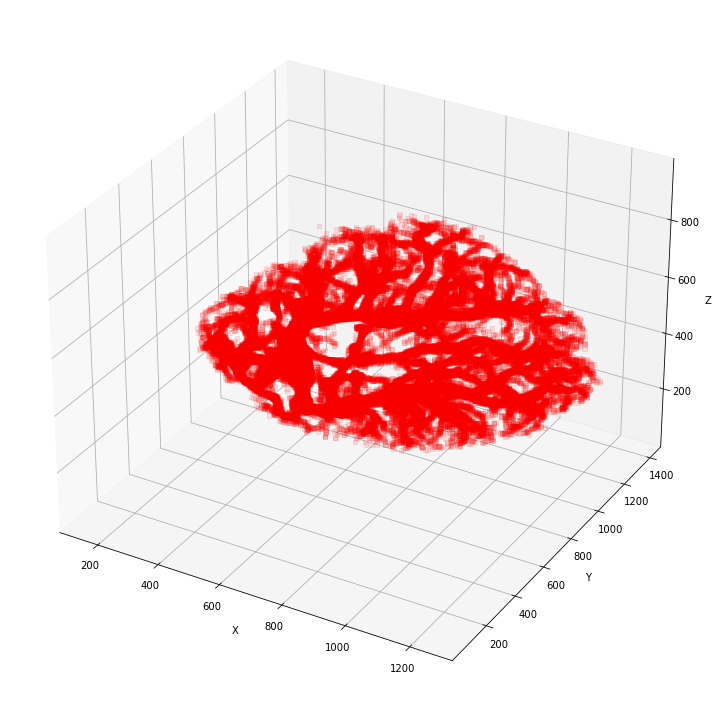

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread

# Load the TIFF volume
tiff_volume = imread('./hoa_big/hoa/V_ref_test.tif')

# Print the shape of the TIFF volume
print("TIFF volume shape:", tiff_volume.shape)

# Create a figure and 3D axes
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Get the coordinates of non-zero voxels
non_zero = np.nonzero(tiff_volume)

# Downsample if there are too many points
max_points = 100000  # Adjust this value based on your computer's capabilities
if len(non_zero[0]) > max_points:
    step = len(non_zero[0]) // max_points
    non_zero = tuple(coord[::step] for coord in non_zero)

# Plot the non-zero voxels
ax.scatter(non_zero[2], non_zero[1], non_zero[0], c='red', marker='s', alpha=0.1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.tight_layout()
plt.show()

## Create skeleton from tiff volume + visualize (GROUND TRUTH)

This I only have it for the reference volume, the other one I have only the skeleton created from chunks

In [29]:
import numpy as np
from tifffile import imread, imsave
from skimage.morphology import skeletonize

# Load the TIFF volume
tiff_volume = imread('./hoa_big/hoa/V_ref_test.tif')

# Convert to binary if necessary
# Adjust the threshold as needed for your specific data
binary_volume = tiff_volume > 0

# Skeletonize the volume
skeleton = skeletonize(binary_volume)

# Save the skeletonized volume as a .tiff file
imsave('skeleton.tif', skeleton.astype(np.uint8) * 255)

In [33]:
import numpy as np

# Ensure skeleton is of type float64
skeleton = skeleton.astype(np.float64)

# Save the skeletonized volume as a .npy file
np.save('skeleton_ref.npy', skeleton)

MemoryError: Unable to allocate 19.9 GiB for an array with shape (1035, 1706, 1510) and data type float64

In [34]:
import pyvista as pv
import numpy as np

# Assuming 'skeleton' is your skeletonized numpy array from earlier
def visualize_3d_skeleton(skeleton):
    # Create a pyvista grid from the skeleton
    # PyVista expects the skeleton in (x, y, z) format, so we transpose the array
    points = np.argwhere(skeleton)  # Get the indices of the non-zero points (the skeleton)

    # Create a point cloud from the skeleton points
    cloud = pv.PolyData(points)

    # Create a pyvista plotter object
    plotter = pv.Plotter()

    # Add the point cloud to the plotter
    plotter.add_mesh(cloud, color='red', point_size=1)

    # Add some labels or axis if you like
    plotter.add_axes()

    # Show the plot
    plotter.show()

# Visualize the 3D skeleton
visualize_3d_skeleton(skeleton)

C:\Users\rita0\anaconda3\lib\site-packages\pyvista\core\utilities\points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:54924/index.html?ui=P_0x18aa5401d30_1&reconnect=auto" class="pyvis…

## Create Skeleton from tiff volume + visualize (UNET RESULT)
Per problema de memòria, provarem de fer-ho amb smaller chunks

In [1]:
import numpy as np
from tifffile import imread, imsave
from skimage.morphology import skeletonize

# Load the TIFF volume
tiff_volume = imread('./hoa_big/hoa/V_unet_test.tif')

# Process in chunks
chunk_size = 100  # Adjust this based on your available memory
skeleton_chunks = []

for i in range(0, tiff_volume.shape[0], chunk_size):
    chunk = tiff_volume[i:i+chunk_size]
    binary_chunk = chunk > 0
    skeleton_chunk = skeletonize(binary_chunk)
    skeleton_chunks.append(skeleton_chunk)

# Combine chunks
skeleton = np.concatenate(skeleton_chunks, axis=0)

# Save the skeletonized volume as a .tiff file
imsave('skeleton_unet.tif', skeleton.astype(np.uint8) * 255)

In [2]:
import pyvista as pv
import numpy as np

# Assuming 'skeleton' is your skeletonized numpy array from earlier
def visualize_3d_skeleton(skeleton):
    # Create a pyvista grid from the skeleton
    # PyVista expects the skeleton in (x, y, z) format, so we transpose the array
    points = np.argwhere(skeleton)  # Get the indices of the non-zero points (the skeleton)

    # Create a point cloud from the skeleton points
    cloud = pv.PolyData(points)

    # Create a pyvista plotter object
    plotter = pv.Plotter()

    # Add the point cloud to the plotter
    plotter.add_mesh(cloud, color='red', point_size=1)

    # Add some labels or axis if you like
    plotter.add_axes()

    # Show the plot
    plotter.show()

# Visualize the 3D skeleton
visualize_3d_skeleton(skeleton)

C:\Users\rita0\anaconda3\lib\site-packages\pyvista\core\utilities\points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:56651/index.html?ui=P_0x22a1564ffa0_0&reconnect=auto" class="pyvis…

In [3]:
print(type(skeleton))

<class 'numpy.ndarray'>


## Provant d'aplicar Mean Centerline Distance
Entre ground truth i resnet

In [ ]:
# aquest codi m'està donant un error de memòria
import numpy as np
from scipy.spatial.distance import cdist
from tifffile import imread

def mean_centerline_distance(skeleton1, skeleton2):
    # Get coordinates of non-zero points in both skeletons
    coords1 = np.array(np.nonzero(skeleton1)).T
    coords2 = np.array(np.nonzero(skeleton2)).T
    
    # Compute distances from each point in skeleton1 to all points in skeleton2
    distances = cdist(coords1, coords2)
    
    # Find the minimum distance for each point in skeleton1
    min_distances = np.min(distances, axis=1)
    
    # Compute the mean of these minimum distances
    mcd = np.mean(min_distances)
    
    return mcd

# Load the skeletons
ground_truth = imread('skeleton.tif')
resnet_result = imread('skeleton_unet.tif')

# Ensure the skeletons are binary
ground_truth = ground_truth.astype(bool)
resnet_result = resnet_result.astype(bool)

# Compute MCD in both directions
mcd_gt_to_resnet = mean_centerline_distance(ground_truth, resnet_result)
mcd_resnet_to_gt = mean_centerline_distance(resnet_result, ground_truth)

# The final MCD is the average of both directions
final_mcd = (mcd_gt_to_resnet + mcd_resnet_to_gt) / 2

print(f"Mean Centerline Distance: {final_mcd}")

#### Amb això d'aquí baix ho fem a chunks a veure si així funciona 

In [12]:
import numpy as np
from scipy.spatial import cKDTree
from tifffile import imread

def mean_centerline_distance_chunked(skeleton1, skeleton2, chunk_size=10000):
    # Get coordinates of non-zero points in both skeletons
    coords1 = np.array(np.nonzero(skeleton1)).T
    coords2 = np.array(np.nonzero(skeleton2)).T
    
    # Build KD-Tree for faster nearest neighbor search
    tree = cKDTree(coords2)
    
    total_distance = 0
    total_points = 0
    
    # Process coords1 in chunks
    for i in range(0, len(coords1), chunk_size):
        chunk = coords1[i:i+chunk_size]
        
        # Find nearest neighbors for this chunk
        distances, _ = tree.query(chunk, k=1)
        
        total_distance += np.sum(distances)
        total_points += len(chunk)
    
    # Compute mean distance
    mcd = total_distance / total_points if total_points > 0 else 0
    
    return mcd

# Load the skeletons
ground_truth = imread('skeleton.tif')
resnet_result = imread('skeleton_unet.tif')

# Ensure the skeletons are binary
ground_truth = ground_truth.astype(bool)
resnet_result = resnet_result.astype(bool)

# Compute MCD in both directions
print("Computing MCD from ground truth to ResNet result...")
mcd_gt_to_resnet = mean_centerline_distance_chunked(ground_truth, resnet_result)

print("Computing MCD from ResNet result to ground truth...")
mcd_resnet_to_gt = mean_centerline_distance_chunked(resnet_result, ground_truth)

# The final MCD is the average of both directions
final_mcd = (mcd_gt_to_resnet + mcd_resnet_to_gt) / 2

print(f"Mean Centerline Distance: {final_mcd}")

Computing MCD from ground truth to ResNet result...
Computing MCD from ResNet result to ground truth...
Mean Centerline Distance: 6.126105423784719


In [3]:
#Per això necessítaríem tenir un factor de conversió de voxel a mm
# After calculating final_mcd
voxel_size_mm = [0.4, 0.4, 0.4]  # Example: 0.4 mm per voxel in each dimension
final_mcd_mm = final_mcd * np.mean(voxel_size_mm)

print(f"Mean Centerline Distance: {final_mcd} voxels")
print(f"Mean Centerline Distance: {final_mcd_mm} mm")

Mean Centerline Distance: 6.126105423784719 voxels
Mean Centerline Distance: 2.450442169513888 mm


## Coverage percentage
A point on centerline A is covered by centerline B if
the closest point on B is within half a voxel 

In [26]:
import numpy as np
from scipy.spatial import cKDTree
from tifffile import imread

def coverage_percentage(centerline_a, centerline_b, voxel_size=1):
    # Extract coordinates of non-zero points in both centerlines
    coords_a = np.array(np.nonzero(centerline_a)).T
    coords_b = np.array(np.nonzero(centerline_b)).T
    
    # Build KD-Tree for centerline B
    tree_b = cKDTree(coords_b)
    
    # Compute distances from each point in A to its nearest point in B
    distances, _ = tree_b.query(coords_a)
    
    # Calculate number of covered points (within half a voxel)
    half_voxel_distance = 0.5 * voxel_size
    covered_points = np.sum(distances <= half_voxel_distance)
    
    # Calculate coverage percentage
    coverage_percentage = (covered_points / len(coords_a)) * 100
    
    return coverage_percentage

# Load the skeletons (centerlines)
centerline_groundtruth = imread('skeleton.tif')
centerline_unet = imread('skeleton_unet.tif')

# Ensure the skeletons are binary
centerline_groundtruth = centerline_groundtruth.astype(bool)
centerline_unet = centerline_unet.astype(bool)

# Calculate coverage percentage
coverage = coverage_percentage(centerline_groundtruth, centerline_unet, voxel_size=1)  # Adjust voxel_size as needed

print(f"Coverage Percentage: {coverage:.2f}%")

Coverage Percentage: 50.80%


#### Estic tenint un coverage molt petit, miraré a veure si puc visualitzar els dos skeletons per entendre coses

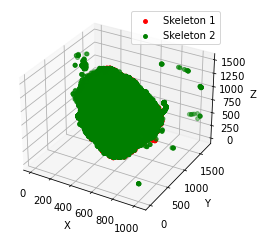

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming skeleton1 and skeleton2 are loaded as before
coords1 = np.array(np.nonzero(skeleton1)).T
coords2 = np.array(np.nonzero(skeleton2)).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coords1[:, 0], coords1[:, 1], coords1[:, 2], c='r', marker='o', s=15, label='Skeleton 1')
ax.scatter(coords2[:, 0], coords2[:, 1], coords2[:, 2], c='g', marker='o', s=15, label='Skeleton 2')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

In [9]:
import pyvista as pv
import numpy as np

def visualize_3d_skeletons(skeleton1, skeleton2):
    # Create point clouds from the skeleton points
    points1 = np.argwhere(skeleton1)
    points2 = np.argwhere(skeleton2)
    
    cloud1 = pv.PolyData(points1)
    cloud2 = pv.PolyData(points2)

    # Create a pyvista plotter object
    plotter = pv.Plotter()

    # Add the point clouds to the plotter with different colors
    plotter.add_mesh(cloud1, color='red', point_size=5, label='Skeleton 1')
    plotter.add_mesh(cloud2, color='blue', point_size=5, label='Skeleton 2')

    # Add axes and a legend
    plotter.add_axes()
    plotter.add_legend()

    # Show the plot
    plotter.show()

# Assuming you have two skeletons: skeleton1 and skeleton2
# Load your skeletons here, for example:
# skeleton1 = imread('path/to/skeleton1.tif').astype(bool)
# skeleton2 = imread('path/to/skeleton2.tif').astype(bool)

# Visualize the 3D skeletons
visualize_3d_skeletons(skeleton1, skeleton2)

C:\Users\rita0\anaconda3\lib\site-packages\pyvista\core\utilities\points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:59530/index.html?ui=P_0x1df0b984d60_1&reconnect=auto" class="pyvis…

### Fent skeleton ground truth amb chunks i comparant els resultats de mean centerline i coverage

In [10]:
import numpy as np
from tifffile import imread, imsave
from skimage.morphology import skeletonize

# Load the TIFF volume
tiff_volume = imread('./hoa_big/hoa/V_ref_test.tif')

# Process in chunks
chunk_size = 100  # Adjust this based on your available memory
skeleton_chunks = []

for i in range(0, tiff_volume.shape[0], chunk_size):
    chunk = tiff_volume[i:i+chunk_size]
    binary_chunk = chunk > 0
    skeleton_chunk = skeletonize(binary_chunk)
    skeleton_chunks.append(skeleton_chunk)

# Combine chunks
skeleton = np.concatenate(skeleton_chunks, axis=0)

# Save the skeletonized volume as a .tiff file
imsave('skeleton_gtchunks.tif', skeleton.astype(np.uint8) * 255)

In [38]:
# Load the skeletons
ground_truth = imread('skeleton_gtchunks.tif')
resnet_result = imread('skeleton_unet.tif')

# Ensure the skeletons are binary
ground_truth = ground_truth.astype(bool)
resnet_result = resnet_result.astype(bool)

# Compute MCD in both directions
print("Computing MCD from ground truth to ResNet result...")
mcd_gt_to_resnet = mean_centerline_distance_chunked(ground_truth, resnet_result)

print("Computing MCD from ResNet result to ground truth...")
mcd_resnet_to_gt = mean_centerline_distance_chunked(resnet_result, ground_truth)

# The final MCD is the average of both directions
final_mcd = (mcd_gt_to_resnet + mcd_resnet_to_gt) / 2

print(f"Mean Centerline Distance: {final_mcd}")
print(f"mcd_gt_to_resnet: {mcd_gt_to_resnet}")
print(f"mcd_resnet_to_gt: {mcd_resnet_to_gt}")


Computing MCD from ground truth to ResNet result...
Computing MCD from ResNet result to ground truth...
Mean Centerline Distance: 6.029056699519639
mcd_gt_to_resnet: 1.2350226970460114
mcd_resnet_to_gt: 10.823090701993268


In [12]:
# Calculate coverage percentage
coverage = coverage_percentage(ground_truth, resnet_result, voxel_size=1)  # Adjust voxel_size as needed

print(f"Coverage Percentage: {coverage:.2f}%")

Coverage Percentage: 52.05%


In [13]:
# Sense chunks
#Mean Centerline Distance: 6.126105423784719 voxels
#Coverage Percentage: 50.80%

### Aplicar mean centerline i coverage canviant l'ordre (a: resnet i b: ground truth)

In [14]:
# Load the skeletons
ground_truth = imread('skeleton_unet.tif')
resnet_result = imread('skeleton_gtchunks.tif')

# Ensure the skeletons are binary
ground_truth = ground_truth.astype(bool)
resnet_result = resnet_result.astype(bool)

# Compute MCD in both directions
print("Computing MCD from ground truth to ResNet result...")
mcd_gt_to_resnet = mean_centerline_distance_chunked(ground_truth, resnet_result)

print("Computing MCD from ResNet result to ground truth...")
mcd_resnet_to_gt = mean_centerline_distance_chunked(resnet_result, ground_truth)

# The final MCD is the average of both directions
final_mcd = (mcd_gt_to_resnet + mcd_resnet_to_gt) / 2

print(f"Mean Centerline Distance: {final_mcd}")

Computing MCD from ground truth to ResNet result...
Computing MCD from ResNet result to ground truth...
Mean Centerline Distance: 6.029056699519639


In [15]:
# Calculate coverage percentage
coverage = coverage_percentage(ground_truth, resnet_result, voxel_size=1)  # Adjust voxel_size as needed

print(f"Coverage Percentage: {coverage:.2f}%")

Coverage Percentage: 29.45%


### Prova d'aplicar Hausdorff distance

In [21]:
import numpy as np
from scipy.spatial import cKDTree

def hausdorff_distance_chunked(GT, UNET, chunk_size=10000):
    # Get coordinates of non-zero points in both skeletons
    GT_points = np.array(np.nonzero(GT)).T
    UNET_points = np.array(np.nonzero(UNET)).T
    
    # Build KD-Tree for UNET points
    tree = cKDTree(UNET_points)
    
    # Initialize max distances
    max_GT_to_UNET = 0
    max_UNET_to_GT = 0
    
    # Process GT points in chunks
    for i in range(0, len(GT_points), chunk_size):
        chunk = GT_points[i:i+chunk_size]
        distances, _ = tree.query(chunk)
        max_GT_to_UNET = max(max_GT_to_UNET, np.max(distances))
    
    # Build KD-Tree for GT points
    tree = cKDTree(GT_points)
    
    # Process UNET points in chunks
    for i in range(0, len(UNET_points), chunk_size):
        chunk = UNET_points[i:i+chunk_size]
        distances, _ = tree.query(chunk)
        max_UNET_to_GT = max(max_UNET_to_GT, np.max(distances))
    
    return max(max_GT_to_UNET, max_UNET_to_GT)

In [22]:
# Load the skeletons
ground_truth = imread('skeleton_gtchunks.tif')
resnet_result = imread('skeleton_unet.tif')

# Ensure the skeletons are binary
ground_truth = ground_truth.astype(bool)
resnet_result = resnet_result.astype(bool)

# Assuming GT and UNET are binary 3D arrays where 1 represents the skeleton
hausdorff_dist = hausdorff_distance_chunked(ground_truth, resnet_result)
print(f"Hausdorff distance: {hausdorff_dist}")

Hausdorff distance: 715.258694459564


In [32]:
import numpy as np
from skimage.io import imread
from skan import Skeleton, summarize

def compute_centerline_length(skeleton_image):
    # Ensure the skeleton is binary
    skeleton = skeleton_image.astype(bool)
    
    # Create a Skeleton object
    sk = Skeleton(skeleton)
    
    # Get the summary of the skeleton
    summary = summarize(sk)
    
    # The total length is the sum of all branch lengths
    total_length = np.sum(summary['branch-distance'])
    
    return total_length

# Load your skeleton images
ground_truth = imread('skeleton_gtchunks.tif')
resnet_result = imread('skeleton_unet.tif')

# Compute lengths
gt_length = compute_centerline_length(ground_truth)
resnet_length = compute_centerline_length(resnet_result)

# Print results
print(f"Ground Truth centerline length: {gt_length}")
print(f"ResNet Result centerline length: {resnet_length}")

# Compute the difference
length_difference = abs(gt_length - resnet_length)

print(f"Absolute difference in length: {length_difference} pixels")

# Compute the relative difference
relative_difference = (length_difference / gt_length) * 100
print(f"Relative difference: {relative_difference:.2f}%")

Ground Truth centerline length: 180691.98803298792
ResNet Result centerline length: 290843.5591110524
Absolute difference in length: 110151.5710780645 pixels
Relative difference: 60.96%


# CHECKING QUE LES FUNCIONS FUNCIONEN:

Visualizing Skeletons:


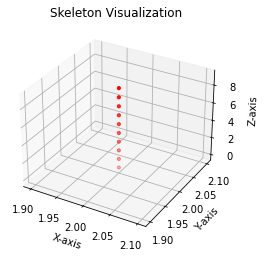

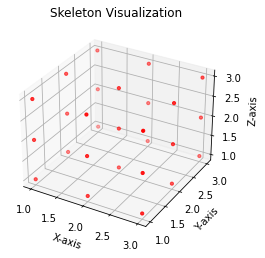

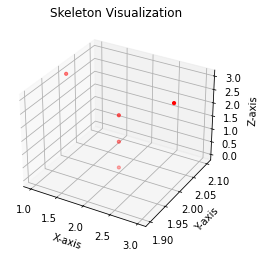

Line Volume Centerline Length: 9.0
Cube Volume Centerline Length: 26.0
Branching Structure Centerline Length: 4.82842712474619


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skan import Skeleton, summarize

def create_line(length=10):
    """Create a straight line skeleton."""
    volume = np.zeros((5, 5, length), dtype=bool)
    volume[2, 2, :] = 1  # A line along the z-axis
    return volume

def create_cube(size=5):
    """Create a cube skeleton."""
    volume = np.zeros((size, size, size), dtype=bool)
    volume[1:size-1, 1:size-1, 1:size-1] = 1  # A filled cube
    return volume

def create_branching_structure():
    """Create a simple branching structure."""
    volume = np.zeros((5, 5, 5), dtype=bool)
    volume[2, 2, 0:3] = 1  # Main trunk
    volume[2, 2, 3] = 0     # Branching point
    volume[1, 2, 3] = 1     # Left branch
    volume[3, 2, 3] = 1     # Right branch
    return volume

# Create volumes
line_volume = create_line(length=10)
cube_volume = create_cube(size=5)
branch_volume = create_branching_structure()

# Function to visualize the skeleton
def visualize_skeleton(volume):
    """Visualize the skeleton extracted from a binary volume."""
    # Create a Skeleton object
    skel = Skeleton(volume)  
    coords = skel.coordinates  # Get coordinates of the skeleton points
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot skeleton points
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='r', marker='o', s=10)
    
    ax.set_title('Skeleton Visualization')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    
    plt.show()

# Visualize skeletons for each volume
print("Visualizing Skeletons:")
visualize_skeleton(line_volume)
visualize_skeleton(cube_volume)
visualize_skeleton(branch_volume)

# Compute lengths for each volume (optional)
def compute_centerline_length(volume):
    """Compute the total centerline length of a given skeleton volume."""
    sk = Skeleton(volume)
    summary = summarize(sk)
    
    total_length = np.sum(summary['branch-distance'])
    
    return total_length

line_length = compute_centerline_length(line_volume)
cube_length = compute_centerline_length(cube_volume)
branch_length = compute_centerline_length(branch_volume)

# Print results
print(f"Line Volume Centerline Length: {line_length}")
print(f"Cube Volume Centerline Length: {cube_length}")
print(f"Branching Structure Centerline Length: {branch_length}")

#### COMPUTE CENTERLINE LENGTH

In [8]:
def compute_centerline_length(volume):
    """Compute the total centerline length of a given skeleton volume."""
    sk = Skeleton(volume)
    summary = summarize(sk)
    
    total_length = np.sum(summary['branch-distance'])
    
    return total_length

# Compute lengths for each volume
line_length = compute_centerline_length(line_volume)
cube_length = compute_centerline_length(cube_volume)
branch_length = compute_centerline_length(branch_volume)

# Print results
print(f"Line Volume Centerline Length: {line_length}")
print(f"Cube Volume Centerline Length: {cube_length}")
print(f"Branching Structure Centerline Length: {branch_length}")

Line Volume Centerline Length: 9.0
Cube Volume Centerline Length: 26.0
Branching Structure Centerline Length: 4.82842712474619


Visualizing Skeletons:


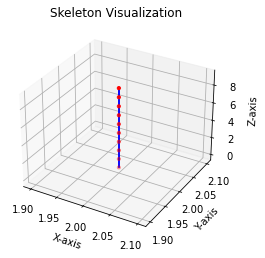

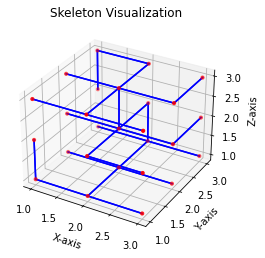

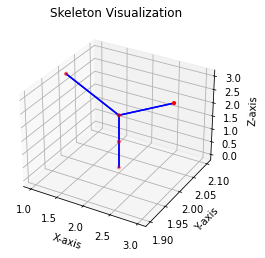

Line Volume Centerline Length: 9.0
Cube Volume Centerline Length: 26.0
Branching Structure Centerline Length: 4.82842712474619


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skan import Skeleton, summarize

def create_line(length=10):
    """Create a straight line skeleton."""
    volume = np.zeros((5, 5, length), dtype=bool)
    volume[2, 2, :] = 1  # A line along the z-axis
    return volume

def create_cube(size=5):
    """Create a cube skeleton."""
    volume = np.zeros((size, size, size), dtype=bool)
    volume[1:size-1, 1:size-1, 1:size-1] = 1  # A filled cube
    return volume

def create_branching_structure():
    """Create a simple branching structure."""
    volume = np.zeros((5, 5, 5), dtype=bool)
    volume[2, 2, 0:3] = 1  # Main trunk
    volume[2, 2, 3] = 0     # Branching point
    volume[1, 2, 3] = 1     # Left branch
    volume[3, 2, 3] = 1     # Right branch
    return volume

# Create volumes
line_volume = create_line(length=10)
cube_volume = create_cube(size=5)
branch_volume = create_branching_structure()

# Function to visualize the skeleton
def visualize_skeleton(volume):
    """Visualize the skeleton extracted from a binary volume."""
    # Create a Skeleton object
    skel = Skeleton(volume)  
    coords = skel.coordinates  # Get coordinates of the skeleton points
    
    # Create a figure for visualization
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot skeleton points
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='r', marker='o', s=10)

    # Draw lines between connected points in the skeleton
    for i in range(skel.graph.shape[0]):  # Use shape[0] instead of len()
        for j in range(skel.graph.shape[1]):
            if skel.graph[i, j]:  # Check if there's a connection
                ax.plot([coords[i][0], coords[j][0]], 
                        [coords[i][1], coords[j][1]], 
                        [coords[i][2], coords[j][2]], color='b')

    ax.set_title('Skeleton Visualization')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    
    plt.show()

# Visualize skeletons for each volume
print("Visualizing Skeletons:")
visualize_skeleton(line_volume)
visualize_skeleton(cube_volume)
visualize_skeleton(branch_volume)

# Compute lengths for each volume (optional)
def compute_centerline_length(volume):
    """Compute the total centerline length of a given skeleton volume."""
    sk = Skeleton(volume)
    summary = summarize(sk)
    
    total_length = np.sum(summary['branch-distance'])
    
    return total_length

line_length = compute_centerline_length(line_volume)
cube_length = compute_centerline_length(cube_volume)
branch_length = compute_centerline_length(branch_volume)

# Print results
print(f"Line Volume Centerline Length: {line_length}")
print(f"Cube Volume Centerline Length: {cube_length}")
print(f"Branching Structure Centerline Length: {branch_length}")

In [ ]:
########### FUNCIONA!!!!!!!!!!!!!!!!!!

### CHECKING QUE MEAN CENTERLINE DIST I COVERAGE FUNCIONEN!

Visualizing Ground Truth Skeleton:


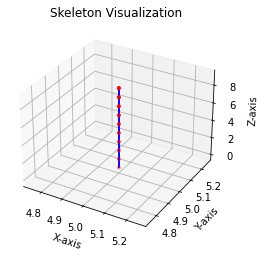

Visualizing Predicted Skeleton:


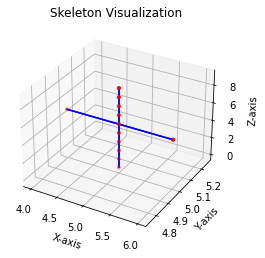

Mean Centerline Distance (Ground Truth to Predicted): 0.00
Mean Centerline Distance (Predicted to Ground Truth): 0.17
Coverage Percentage (Ground Truth covered by Predicted): 100.00%
Coverage Percentage (Predicted covered by Ground Truth): 83.33%


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skan import Skeleton, summarize

def create_ground_truth_skeleton():
    """Create a simple ground truth skeleton."""
    volume = np.zeros((10, 10, 10), dtype=bool)
    volume[5, 5, :] = 1  # A straight line along the z-axis
    return volume

def create_predicted_skeleton():
    """Create a predicted skeleton with some variations."""
    volume = np.zeros((10, 10, 10), dtype=bool)
    volume[5, 5, :] = 1  # A straight line along the z-axis
    volume[4, 5, 5] = 1   # Adding a small deviation
    volume[6, 5, 5] = 1   # Adding another small deviation
    return volume

# Create volumes
ground_truth_volume = create_ground_truth_skeleton()
predicted_volume = create_predicted_skeleton()

# Visualize the skeletons
def visualize_skeleton(volume):
    """Visualize the skeleton extracted from a binary volume."""
    skel = Skeleton(volume)  
    coords = skel.coordinates  
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot skeleton points
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='r', marker='o', s=10)

    # Draw lines between connected points in the skeleton
    for i in range(skel.graph.shape[0]):
        for j in range(skel.graph.shape[1]):
            if skel.graph[i, j]:
                ax.plot([coords[i][0], coords[j][0]], 
                        [coords[i][1], coords[j][1]], 
                        [coords[i][2], coords[j][2]], color='b')

    ax.set_title('Skeleton Visualization')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    
    plt.show()

# Visualize both skeletons
print("Visualizing Ground Truth Skeleton:")
visualize_skeleton(ground_truth_volume)
print("Visualizing Predicted Skeleton:")
visualize_skeleton(predicted_volume)

# Function to compute mean centerline distance
def mean_centerline_distance(skeleton_a, skeleton_b):
    """Compute the mean centerline distance between two skeletons."""
    sk_a = Skeleton(skeleton_a)
    sk_b = Skeleton(skeleton_b)
    
    # Get coordinates of non-zero points in both skeletons
    coords_a = sk_a.coordinates
    coords_b = sk_b.coordinates
    
    # Calculate pairwise distances between points in A and B
    distances = np.linalg.norm(coords_a[:, None] - coords_b[None, :], axis=-1)
    
    # Find minimum distance for each point in A to any point in B
    min_distances_a_to_b = np.min(distances, axis=1)
    
    # Find minimum distance for each point in B to any point in A
    min_distances_b_to_a = np.min(distances, axis=0)
    
    # Calculate mean distances
    mean_distance_a_to_b = np.mean(min_distances_a_to_b)
    mean_distance_b_to_a = np.mean(min_distances_b_to_a)

    return mean_distance_a_to_b, mean_distance_b_to_a

# Compute mean centerline distances
mean_distance_ab, mean_distance_ba = mean_centerline_distance(ground_truth_volume, predicted_volume)

print(f"Mean Centerline Distance (Ground Truth to Predicted): {mean_distance_ab:.2f}")
print(f"Mean Centerline Distance (Predicted to Ground Truth): {mean_distance_ba:.2f}")

# Function to compute coverage percentage
def coverage_percentage(skeleton_a, skeleton_b):
    """Calculate coverage percentage of skeleton A by skeleton B."""
    coords_a = np.array(np.nonzero(skeleton_a)).T
    coords_b = np.array(np.nonzero(skeleton_b)).T
    
    tree_b = cKDTree(coords_b)
    
    distances, _ = tree_b.query(coords_a)
    
    half_voxel_distance = 0.5  # Assuming voxel size of 1 for simplicity
    covered_points = np.sum(distances <= half_voxel_distance)
    
    coverage_pct = (covered_points / len(coords_a)) * 100
    
    return coverage_pct

# Compute coverage percentage
coverage_ab = coverage_percentage(ground_truth_volume, predicted_volume)
coverage_ab2 = coverage_percentage(predicted_volume, ground_truth_volume)


print(f"Coverage Percentage (Ground Truth covered by Predicted): {coverage_ab:.2f}%")
print(f"Coverage Percentage (Predicted covered by Ground Truth): {coverage_ab2:.2f}%")

Visualizing Ground Truth Skeleton:


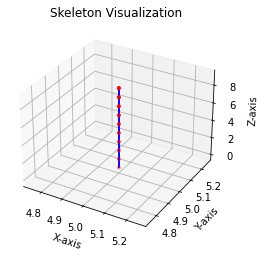

Visualizing Predicted Skeleton:


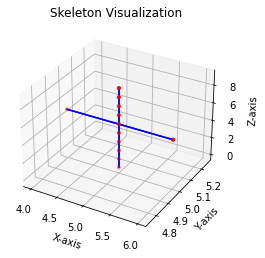

Mean Centerline Distance (Ground Truth to Predicted): 0.00
Mean Centerline Distance (Predicted to Ground Truth): 0.16667
Coverage Percentage (Ground Truth covered by Predicted): 100.00%
Coverage Percentage (Predicted covered by Ground Truth): 83.33%


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skan import Skeleton, summarize

def create_ground_truth_skeleton():
    """Create a simple ground truth skeleton."""
    volume = np.zeros((10, 10, 10), dtype=bool)
    volume[5, 5, :] = 1  # A straight line along the z-axis
    return volume

def create_predicted_skeleton():
    """Create a predicted skeleton with some variations."""
    volume = np.zeros((10, 10, 10), dtype=bool)
    volume[5, 5, :] = 1  # A straight line along the z-axis
    volume[4, 5, 5] = 1   # Adding a small deviation
    volume[6, 5, 5] = 1   # Adding another small deviation
    return volume

# Create volumes
ground_truth_volume = create_ground_truth_skeleton()
predicted_volume = create_predicted_skeleton()

# Visualize the skeletons
def visualize_skeleton(volume):
    """Visualize the skeleton extracted from a binary volume."""
    skel = Skeleton(volume)  
    coords = skel.coordinates  
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot skeleton points
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='r', marker='o', s=10)

    # Draw lines between connected points in the skeleton
    for i in range(skel.graph.shape[0]):
        for j in range(skel.graph.shape[1]):
            if skel.graph[i, j]:
                ax.plot([coords[i][0], coords[j][0]], 
                        [coords[i][1], coords[j][1]], 
                        [coords[i][2], coords[j][2]], color='b')

    ax.set_title('Skeleton Visualization')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    
    plt.show()

# Visualize both skeletons
print("Visualizing Ground Truth Skeleton:")
visualize_skeleton(ground_truth_volume)
print("Visualizing Predicted Skeleton:")
visualize_skeleton(predicted_volume)

# Function to compute mean centerline distance
def mean_centerline_distance(skeleton_a, skeleton_b):
    """Compute the mean centerline distance between two skeletons."""
    sk_a = Skeleton(skeleton_a)
    sk_b = Skeleton(skeleton_b)
    
    # Get coordinates of non-zero points in both skeletons
    coords_a = sk_a.coordinates
    coords_b = sk_b.coordinates
    
    # Calculate pairwise distances between points in A and B
    distances = np.linalg.norm(coords_a[:, None] - coords_b[None, :], axis=-1)
    
    # Find minimum distance for each point in A to any point in B
    min_distances_a_to_b = np.min(distances, axis=1)
    
    # Find minimum distance for each point in B to any point in A
    min_distances_b_to_a = np.min(distances, axis=0)
    
    # Calculate mean distances
    mean_distance_a_to_b = np.mean(min_distances_a_to_b)
    mean_distance_b_to_a = np.mean(min_distances_b_to_a)

    return mean_distance_a_to_b, mean_distance_b_to_a

# Compute mean centerline distances
mean_distance_ab, mean_distance_ba = mean_centerline_distance(ground_truth_volume, predicted_volume)

print(f"Mean Centerline Distance (Ground Truth to Predicted): {mean_distance_ab:.2f}")
print(f"Mean Centerline Distance (Predicted to Ground Truth): {mean_distance_ba:.5f}")

# Function to compute coverage percentage
def coverage_percentage(skeleton_a, skeleton_b):
    """Calculate coverage percentage of skeleton A by skeleton B."""
    coords_a = np.array(np.nonzero(skeleton_a)).T
    coords_b = np.array(np.nonzero(skeleton_b)).T
    
    tree_b = cKDTree(coords_b)
    
    distances, _ = tree_b.query(coords_a)
    
    half_voxel_distance = 0.5  # Assuming voxel size of 1 for simplicity
    covered_points = np.sum(distances <= half_voxel_distance)
    
    coverage_pct = (covered_points / len(coords_a)) * 100
    
    return coverage_pct

# Compute coverage percentage
coverage_ab = coverage_percentage(ground_truth_volume, predicted_volume)
coverage_ab2 = coverage_percentage(predicted_volume, ground_truth_volume)


print(f"Coverage Percentage (Ground Truth covered by Predicted): {coverage_ab:.2f}%")
print(f"Coverage Percentage (Predicted covered by Ground Truth): {coverage_ab2:.2f}%")

In [24]:
import numpy as np
from scipy.spatial import cKDTree
from tifffile import imread

def mean_centerline_distance_chunked(skeleton1, skeleton2, chunk_size=10000):
    # Get coordinates of non-zero points in both skeletons
    coords1 = np.array(np.nonzero(skeleton1)).T
    coords2 = np.array(np.nonzero(skeleton2)).T
    
    # Build KD-Tree for faster nearest neighbor search
    tree = cKDTree(coords2)
    
    total_distance = 0
    total_points = 0
    
    # Process coords1 in chunks
    for i in range(0, len(coords1), chunk_size):
        chunk = coords1[i:i+chunk_size]
        
        # Find nearest neighbors for this chunk
        distances, _ = tree.query(chunk, k=1)
        
        total_distance += np.sum(distances)
        total_points += len(chunk)
    
    # Compute mean distance
    mcd = total_distance / total_points if total_points > 0 else 0
    
    return mcd

# Load the skeletons
ground_truth = Skeleton(ground_truth_volume)
resnet_result = Skeleton(predicted_volume)

# Ensure the skeletons are binary
#ground_truth = ground_truth.astype(bool)
#resnet_result = resnet_result.astype(bool)

# Compute MCD in both directions
print("Computing MCD from ground truth to ResNet result...")
mcd_gt_to_resnet = mean_centerline_distance_chunked(ground_truth, resnet_result)

print("Computing MCD from ResNet result to ground truth...")
mcd_resnet_to_gt = mean_centerline_distance_chunked(resnet_result, ground_truth)

# The final MCD is the average of both directions
final_mcd = (mcd_gt_to_resnet + mcd_resnet_to_gt) / 2

print(f"Mean Centerline Distance: {final_mcd}")

Computing MCD from ground truth to ResNet result...
Computing MCD from ResNet result to ground truth...
Mean Centerline Distance: 0.08333333333333333


In [29]:
coverage = coverage_percentage(resnet_result, ground_truth, voxel_size=1)  # Adjust voxel_size as needed

In [30]:
print(f"Coverage Percentage: {coverage:.2f}%")

Coverage Percentage: 83.33%


In [37]:
import numpy as np
from skimage.io import imread
from skan import Skeleton, summarize

def compute_centerline_length(skeleton_image):
    # Ensure the skeleton is binary
    #skeleton = skeleton_image.astype(bool)
    
    # Create a Skeleton object
    #sk = Skeleton(skeleton_image)
    
    # Get the summary of the skeleton
    summary = summarize(skeleton_image)
    
    # The total length is the sum of all branch lengths
    total_length = np.sum(summary['branch-distance'])
    
    return total_length

# Load your skeleton images
ground_truth = Skeleton(ground_truth_volume)
resnet_result = Skeleton(predicted_volume)

# Compute lengths
gt_length = compute_centerline_length(ground_truth)
resnet_length = compute_centerline_length(resnet_result)

# Print results
print(f"Ground Truth centerline length: {gt_length}")
print(f"ResNet Result centerline length: {resnet_length}")

Ground Truth centerline length: 9.0
ResNet Result centerline length: 11.0


In [3]:
pip install --user skan

  Using cached skan-0.11.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached imageio-2.36.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
  Using cached numba-0.60.0-cp39-cp39-win_amd64.whl.metadata (2.8 kB)
  Using cached llvmlite-0.43.0-cp39-cp39-win_amd64.whl.metadata (4.9 kB)
Using cached skan-0.11.1-py3-none-any.whl (1.5 MB)
Using cached imageio-2.36.0-py3-none-any.whl (315 kB)
Using cached numba-0.60.0-cp39-cp39-win_amd64.whl (2.7 MB)
Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl (11.6 MB)
Using cached llvmlite-0.43.0-cp39-cp39-win_amd64.whl (28.1 MB)



DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install --ignore-installed skan

  Using cached skan-0.11.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached imageio-2.36.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached numba-0.60.0-cp39-cp39-win_amd64.whl.metadata (2.8 kB)


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\rita0\\anaconda3\\Lib\\site-packages\\PIL\\_imaging.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 59.7/59.7 kB 3.3 MB/s eta 0:00:00
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
     ---------------------------------------- 60.6/60.6 kB ? eta 0:00:00
     ---------------------------------------- 57.6/57.6 kB ? eta 0:00:00
     -------------------------------------- 167.0/167.0 kB 9.8 MB/s eta 0:00:00
  Using cached llvmlite-0.43.0-cp39-cp39-win_amd64.whl.metadata (4.9 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached skan-0.11.1-py3-none-any.whl (1.5 MB)
Using cached imageio-2.36.0-py3-none-any.whl (315 kB)
   ---------------------------------------- 7.8/7.8 MB 33.3 MB/s eta 0:00:00
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Using cached numba-0.60.0-cp39-cp39-win_amd64.whl (2.7 MB)
   ---------------------------------------- 15.9/15.9 MB 54.7 MB/s eta 0:00:00
   --------------------------------------- 250.9/250.9 kB 15.0 MB/s eta 0:00:00
Using cached pandas-2.2.3-cp3

In [6]:
pip install skan

  Using cached skan-0.11.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached imageio-2.36.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
  Using cached numba-0.60.0-cp39-cp39-win_amd64.whl.metadata (2.8 kB)
  Using cached llvmlite-0.43.0-cp39-cp39-win_amd64.whl.metadata (4.9 kB)
Using cached skan-0.11.1-py3-none-any.whl (1.5 MB)
Using cached imageio-2.36.0-py3-none-any.whl (315 kB)
Using cached numba-0.60.0-cp39-cp39-win_amd64.whl (2.7 MB)
Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl (11.6 MB)
Using cached llvmlite-0.43.0-cp39-cp39-win_amd64.whl (28.1 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install matplotlib numpy tifffile

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
pip install numpy tifffile scikit-image

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
